# Object detection using a region-based convolutional neural network (R-CNN)

This project aims at detecting and identifying objects in images. This is achieved using a region-based convolutional neural network (R-CNN) to classify objects across 20 categories and detect them in images using bounding boxes.

While being too slow for real-time object detection, unlike models like You Only Look Once (YOLO), R-CNNs generally present high accuracy and are based on an interesting learning strategy that separates identifying and classifying objects:
1. Image sections are isolated within regions obtained via selective-search segmentation (this is the core of R-CNNs' detection aspect).
2. These sections are then assigned a label based on the ground-truth labels and the sections' similarities to the ground-truth bounding boxes (using intersection over union).
3. The model is trained to classify these image sections.
4. During inference, new regions are generated via selective-search segmentation and fed to the model for classification, with the most relevant regions being later selected based on classification and spatial-overlap criteria (see non-maximum suppression below).

## Data loading

In [32]:
import os
import cv2
import selectivesearch
import pickle

from typing import Tuple, Optional
from numpy.typing import NDArray

import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import trange, tqdm
from typing import Tuple

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import torchvision.models as models

%matplotlib inline

In [225]:
data_dir = './data'
if (not os.path.isdir(data_dir)):
    os.mkdir(data_dir)

fig_dir = './figures'
if (not os.path.isdir(fig_dir)):
    os.mkdir(fig_dir)

# Device
device = torch.device('cuda' if torch.cuda.is_available()
                      else 'mps' if torch.backends.mps.is_available()
                      else 'cpu')

In [7]:
# Data loading
voc_dataset_train = datasets.VOCDetection(root=data_dir,
                                          image_set='train',
                                          download=True,
                                          year='2007')
voc_dataset_val = datasets.VOCDetection(root=data_dir,
                                        image_set='val',
                                        download=True,
                                        year='2007')
voc_dataset_test = datasets.VOCDetection(root=data_dir,
                                         image_set='test',
                                         download=True,
                                         year='2007')

# Dataset labels 
# (Make sure 'background' has index 0 in this list)
data_labels = ['background', 'pottedplant', 'person', 'motorbike',
               'train', 'dog', 'diningtable', 'horse',
               'bus', 'aeroplane', 'sofa', 'sheep',
               'tvmonitor', 'bird', 'bottle', 'chair',
               'cat', 'bicycle', 'cow', 'boat', 'car']

# Number of samples per set
print(f'Number of train samples: {len(voc_dataset_train)}')
print(f'Number of validation samples: {len(voc_dataset_val)}')
print(f'Number of test samples: {len(voc_dataset_test)}')

Using downloaded and verified file: ./data/VOCtrainval_06-Nov-2007.tar
Extracting ./data/VOCtrainval_06-Nov-2007.tar to ./data
Using downloaded and verified file: ./data/VOCtrainval_06-Nov-2007.tar
Extracting ./data/VOCtrainval_06-Nov-2007.tar to ./data
Using downloaded and verified file: ./data/VOCtest_06-Nov-2007.tar
Extracting ./data/VOCtest_06-Nov-2007.tar to ./data
Number of train samples: 2501
Number of validation samples: 2510
Number of test samples: 4952


In [8]:
# Typical data
voc_dataset_train[1]

(<PIL.Image.Image image mode=RGB size=480x364>,
 {'annotation': {'folder': 'VOC2007',
   'filename': '000017.jpg',
   'source': {'database': 'The VOC2007 Database',
    'annotation': 'PASCAL VOC2007',
    'image': 'flickr',
    'flickrid': '228217974'},
   'owner': {'flickrid': 'genewolf', 'name': 'whiskey kitten'},
   'size': {'width': '480', 'height': '364', 'depth': '3'},
   'segmented': '0',
   'object': [{'name': 'person',
     'pose': 'Left',
     'truncated': '0',
     'difficult': '0',
     'bndbox': {'xmin': '185', 'ymin': '62', 'xmax': '279', 'ymax': '199'}},
    {'name': 'horse',
     'pose': 'Left',
     'truncated': '0',
     'difficult': '0',
     'bndbox': {'xmin': '90', 'ymin': '78', 'xmax': '403', 'ymax': '336'}}]}})

In [ ]:
def draw_image_boxes(img: NDArray,
                     boxes: list[list[int]],
                     scores: list[float],
                     labels: Optional[list[str]] = None,
                     color_box: list[int] = [255, 0, 0],
                     color_text: list[int] = [0, 230, 0]) -> NDArray:
    for i in range(len(boxes)):
        box_coordinates = tuple(np.array(boxes[i]).astype(np.int32))
        x1y1 = box_coordinates[0:2]
        x2y2 = box_coordinates[2:4]

        img = cv2.rectangle(img,
                            pt1=x1y1,
                            pt2=x2y2,
                            color=color_box,
                            thickness=2)
        if labels is not None:
            img = cv2.putText(img,
                              text=f'{labels[i]} {scores[i]:.4f}',
                              org=x1y1,
                              fontFace=cv2.FONT_HERSHEY_COMPLEX_SMALL,
                              fontScale=1,
                              color=color_text,
                              thickness=2)

    return img

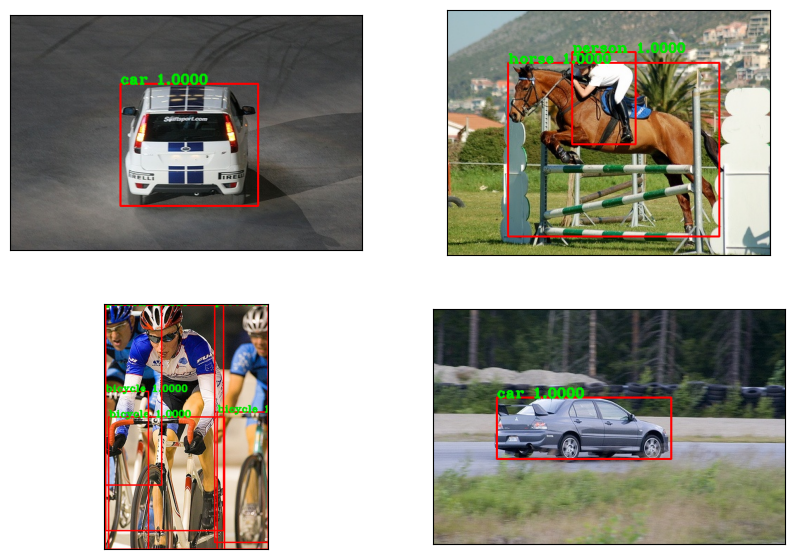

In [226]:
# Let us visualize a few images
_, ax = plt.subplots(2, 2, figsize=(10, 7))
ax = ax.flatten()

for i in range(4):
    image, annotations = voc_dataset_train[i]

    image = np.array(image)
    box_annotations = annotations['annotation']['object']
    boxes = [[int(v) for _, v in x['bndbox'].items()] for x in box_annotations]
    labels = [x["name"] for x in box_annotations]
    scores = [1.]*len(labels)  # The label is certain
    final_image = draw_image_boxes(image, boxes, scores, labels)

    ax[i].imshow(image)
    ax[i].tick_params(axis='both',
                      which='both',
                      left=False,
                      labelleft=False,
                      bottom=False,
                      labelbottom=False)
plt.savefig(os.path.join(fig_dir, '1_example_images.png'),
            bbox_inches='tight', dpi=600)
plt.show()

## Data preparation for model training

We generate image sections for the training and validation datasets using boxes generated via selective-search segmentation. To better train our model, we keep boxes that do not greatly match ground-truth bounding boxes and label them as 0 (background).

In [87]:
def compute_iou(box_1: list[int],
                box_2: list[int]) -> float:
    # Intersection over union

    x1_b1, y1_b1, x2_b1, y2_b1 = tuple(box_1)
    x1_b2, y1_b2, x2_b2, y2_b2 = tuple(box_2)

    x1 = np.maximum(x1_b1, x1_b2)
    y1 = np.maximum(y1_b1, y1_b2)
    x2 = np.minimum(x2_b1, x2_b2)
    y2 = np.minimum(y2_b1, y2_b2)

    area_of_intersection = max(0, x2 - x1 + 1)*max(0, y2 - y1 + 1)
    area_box_1 = (x2_b1 - x1_b1 + 1)*(y2_b1 - y1_b1 + 1)
    area_box_2 = (x2_b2 - x1_b2 + 1)*(y2_b2 - y1_b2 + 1)
    area_of_union = area_box_1 + area_box_2 - area_of_intersection

    return area_of_intersection/float(area_of_union)


def generate_image_sections_from_proposals(image: NDArray,
                                           box_annotations: list[dict],
                                           region_proposals: NDArray,
                                           data_labels: list[str],
                                           iou_threshold: float,
                                           max_n_boxes: int,
                                           fraction_background: float = 0.5
                                           ) -> Tuple[list[NDArray], list[int]]:
    # To better train our model, we keep boxes that do not greatly match
    # ground-truth bounding boxes and label them as 0 (background)
    # (The target is fraction_background*max_n_boxes of such boxes 
    #  and (1-fraction_background)*max_n_boxes boxes that better match the ground-truth)
    background_count = 0
    non_background_count = 0
    max_background_count = int(fraction_background*max_n_boxes)
    max_non_background_count = max_n_boxes - max_background_count
    
    # Go through box annotations and region proposals
    image_sections = []
    classes = []
    for annotation in box_annotations:
        # Ground-truth information
        label = annotation['name']
        box = [int(v) for _, v in annotation['bndbox'].items()]
        box = np.array(box)

        # Select region proposals
        for region in region_proposals:
            if (non_background_count > max_non_background_count) \
                    and (background_count > max_background_count):
                break
            else:
                iou_score = compute_iou(region, box)
                if (iou_score >= iou_threshold) \
                        and (non_background_count <= max_non_background_count):
                    # Keep box containing object
                    x1, y1, x2, y2 = region
                    img_section = image[y1:y2, x1:x2]
                    image_sections.append(img_section)
                    classes.append(data_labels.index(label))
                    non_background_count += 1
                elif background_count <= max_background_count:
                    # Keep box that does not contain an object
                    x1, y1, x2, y2 = region
                    img_section = image[y1:y2, x1:x2]
                    image_sections.append(img_section)
                    classes.append(0)  # Background label
                    background_count += 1

    return image_sections, classes


def prepare_data_for_rcnn(dataset,
                          output_dir: str,
                          iou_threshold: float,
                          max_n_boxes: int,
                          selective_search_params: dict,
                          fraction_background: float = 0.5) -> None:
    # Check if data was not already processed
    if len(os.listdir(output_dir)) < 1000:
        # Read parameters from selective_search_params
        scale = selective_search_params['scale']
        sigma = selective_search_params['sigma']
        min_size = selective_search_params['min_size']
        max_n_proposals = selective_search_params['max_n_proposals']

        all_images = []
        all_labels = []
        for image, annotations in tqdm(dataset):
            image = np.array(image)
            box_annotations = annotations['annotation']['object']

            # Selective search algorithm for generating region proposals 
            # by merging similar pixels into regions
            _, region_proposals \
                = selectivesearch.selective_search(image,
                                                   scale=scale,
                                                   sigma=sigma,
                                                   min_size=min_size)
            region_proposals = [r['rect'] for r in region_proposals]
            region_proposals = [[x, y, x+w, y+h]
                                for x, y, w, h in region_proposals
                                if (w != 0) and (h != 0)]
            region_proposals = np.array(region_proposals[:max_n_proposals])

            # Image sections for RCNN
            image_sections, classes \
                = generate_image_sections_from_proposals(image,
                                                         box_annotations,
                                                         region_proposals,
                                                         data_labels,
                                                         iou_threshold,
                                                         max_n_boxes,
                                                         fraction_background)
            # Concatenate output lists
            all_images += image_sections
            all_labels += classes

        # Saving processed data to pickle file
        for idx, (image, label) in enumerate(zip(all_images, all_labels)):
            pickle_path = os.path.join(output_dir, f'img_{idx}.pkl')
            with open(pickle_path, 'wb') as f:
                pickle.dump({'image': image, 'label': label}, f)
    else:
        print(f'Data already prepared in {output_dir}')

In [24]:
rcnn_train_data_dir = './data_rcnn/train/'
rcnn_val_data_dir = './data_rcnn/val/'
os.makedirs(rcnn_train_data_dir, exist_ok=True)
os.makedirs(rcnn_val_data_dir, exist_ok=True)

iou_threshold = 0.7
max_n_boxes = 50
selective_search_params = {
    'scale': 300.,           # large values result in fewer regions but potentially higher quality
    'sigma': 0.8,            # std of Gaussian function smoothing the image
    'min_size': 50,          # discard too-small regions
    'max_n_proposals': 1000  # maximal number of proposals retained
}
fraction_background = 0.5  # fraction of background image sections in final dataset

prepare_data_for_rcnn(voc_dataset_train,
                      rcnn_train_data_dir,
                      iou_threshold,
                      max_n_boxes,
                      selective_search_params,
                      fraction_background)
prepare_data_for_rcnn(voc_dataset_val,
                      rcnn_val_data_dir,
                      iou_threshold,
                      max_n_boxes,
                      selective_search_params,
                      fraction_background)

Data already prepared in ./data_rcnn/train/
Data already prepared in ./data_rcnn/val/


We now generate the final datasets and data loaders for training and validation.

In [75]:
class RCNNDataset(Dataset):
    def __init__(self,
                 data_folder: str,
                 image_section_dim: Tuple[int, int]) -> None:
        super().__init__()
        self.data_files = list(map(lambda x: os.path.join(data_folder, x),
                                   os.listdir(data_folder)))
        self.image_section_dim = image_section_dim
        self.transform = transforms.Normalize([0.485, 0.456, 0.406],
                                              [0.229, 0.224, 0.225])

    def __getitem__(self, idx: int) -> Tuple[torch.Tensor, torch.Tensor]:
        with open(self.data_files[idx], 'rb') as pkl:
            data = pickle.load(pkl)
        image, label = data['image'], data['label']
        
        # Resize, convert, transform image
        image = cv2.resize(image, self.image_section_dim)
        image = np.asarray(image, dtype=np.float32)
        image = torch.from_numpy(image)
        image = torch.permute(image, (2, 0, 1))
        image = self.transform(image)
        
        # Convert label
        label = torch.tensor(label)
        
        return image, label
    
    def __len__(self) -> int:
        return len(self.data_files)

In [76]:
pixel_size = 224
batch_size = 64

train_dataset = RCNNDataset(data_folder=rcnn_train_data_dir,
                            image_section_dim=(pixel_size, pixel_size))
val_dataset = RCNNDataset(data_folder=rcnn_val_data_dir,
                          image_section_dim=(pixel_size, pixel_size))

train_loader = DataLoader(train_dataset,
                          batch_size=batch_size,
                          shuffle=True)
val_loader = DataLoader(val_dataset,
                        batch_size=batch_size,
                        shuffle=False)

print(f'Number of training samples: {len(train_dataset)}')
print(f'Number of validation samples: {len(val_dataset)}')

Number of training samples: 78494
Number of validation samples: 78872


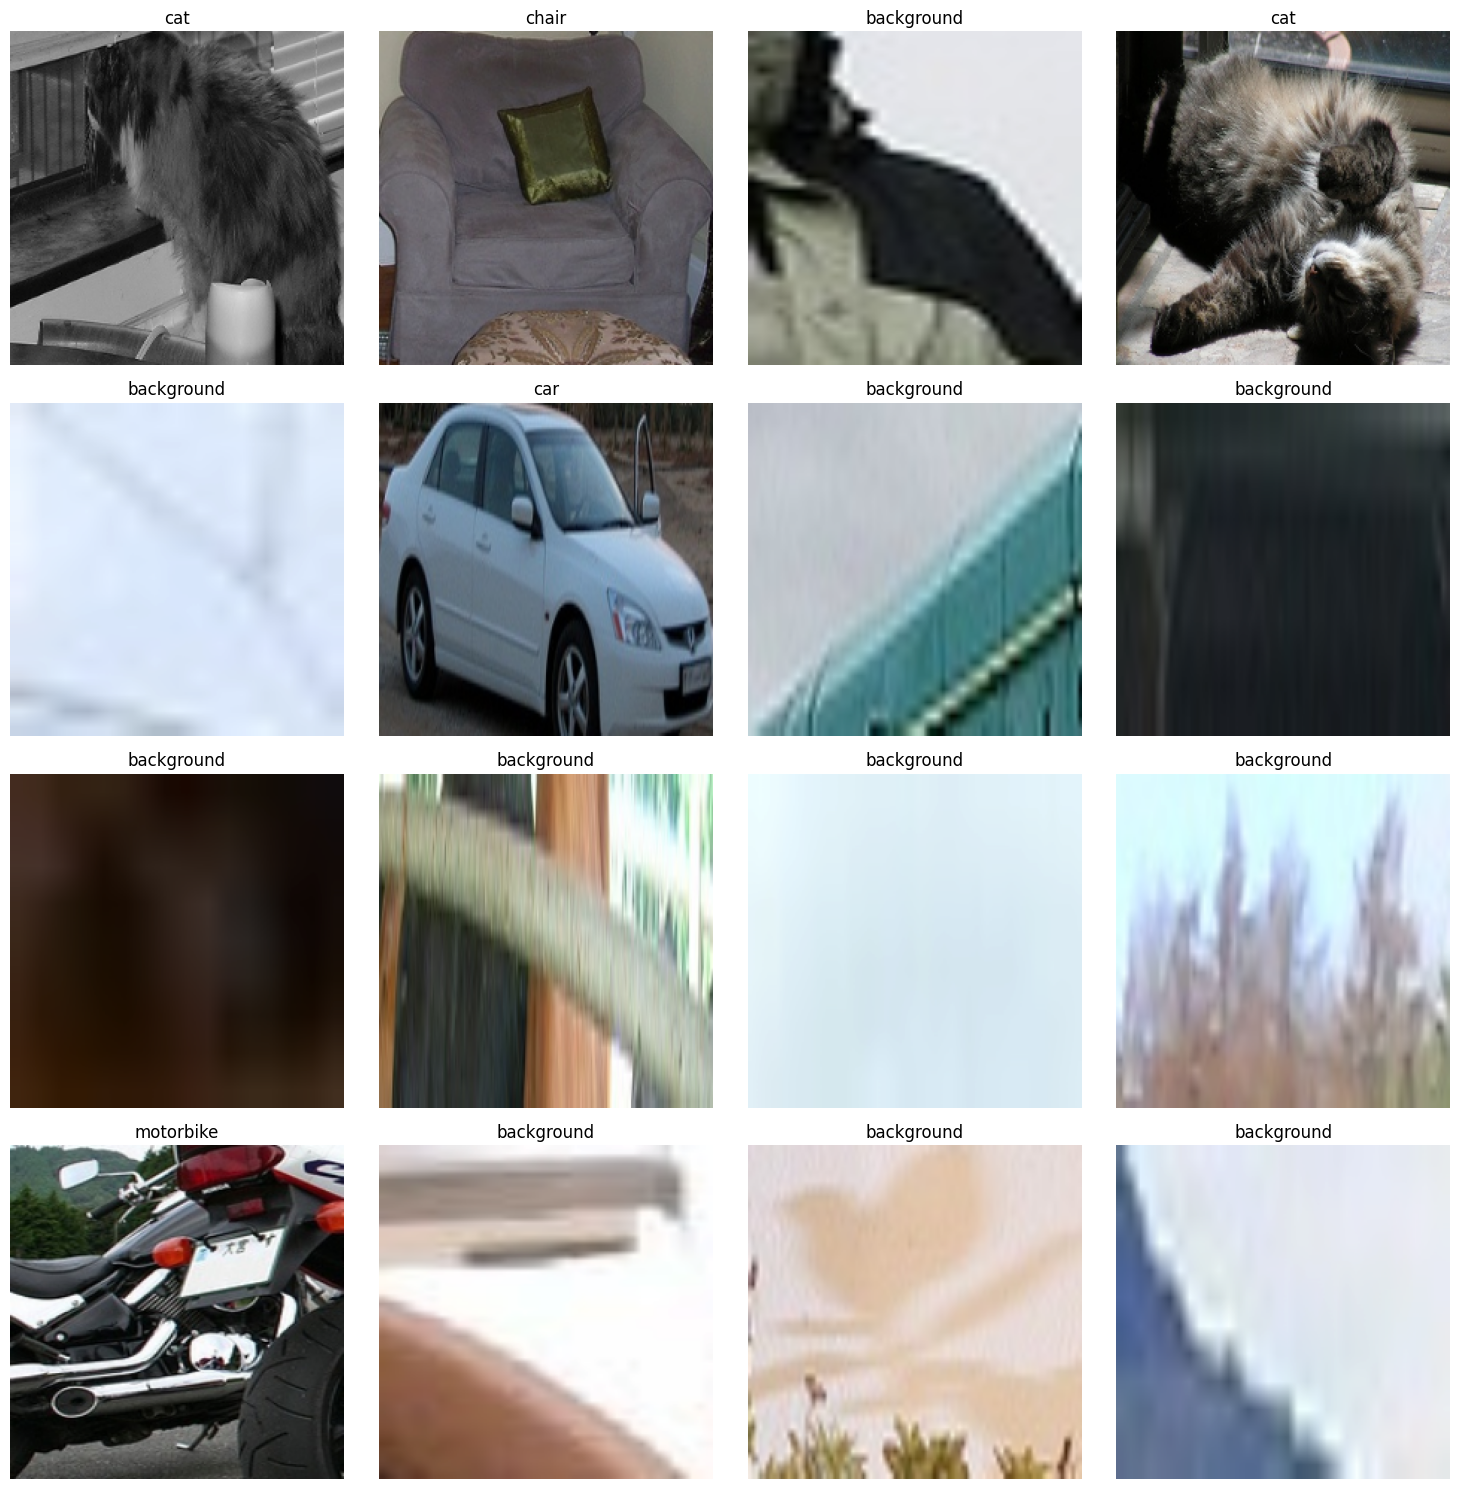

In [229]:
def show_image_sections(image_sections: torch.Tensor,
                        labels: torch.Tensor,
                        n_rows: int,
                        n_cols: int,
                        figsize: Tuple[float, float]) -> None:
    _, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=figsize)
    axes = axes.flatten()

    # Undo normalization transform
    mean = torch.tensor([0.485, 0.456, 0.406]).reshape(1, -1, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).reshape(1, -1, 1, 1)
    image_sections = std * image_sections + mean

    image_sections = image_sections.permute((0, 2, 3, 1))
    image_sections = image_sections.type(torch.uint8)
    for idx, ax in enumerate(axes):
        ax.imshow(image_sections[idx])
        ax.set_title(labels[idx])
        ax.grid(False)
        ax.set_axis_off()
    
    plt.tight_layout(w_pad=0.5)


# Some image sections from the training dataset
image_sections, labels = next(iter(train_loader))
labels = [data_labels[x.item()] for x in labels]
show_image_sections(image_sections,
                    labels,
                    n_rows=4,
                    n_cols=4,
                    figsize=(15, 15))
plt.savefig(os.path.join(fig_dir, '2_example_image_sections.png'),
            bbox_inches='tight', dpi=600)
plt.show()

## Region-based convolutional neural network (R-CNN)

### Definition and transfer learning

We load and freeze a pretrained ResNet50 model as base model and subsequently alter its final classification layer to match our problem, thereby taking advantage of transfer learning.

In [77]:
# Load and freeze pretrained resnet
model = models.resnet50(weights='IMAGENET1K_V2')
for param in model.parameters():
    param.requires_grad = False

# Modify the model's last fully connected layer
# to adapt it to our problem and incorporate dropout
n_labels = len(data_labels)
n_hidden = 512  # Corresponds to n_features/4 below
dropout = 0.2

n_features = model.fc.in_features  # This is 2048 in the original model
model.fc = nn.Sequential(nn.Dropout(dropout),
                         nn.Linear(n_features, n_hidden),
                         nn.Dropout(dropout),
                         nn.Linear(n_hidden, n_labels))

# Transfer model to device
model.to(device)

# Number of parameters
n_params = 0
n_params_train = 0
for param in model.parameters():
    param = param.flatten()
    n_params += param.shape[0]
    n_params_train += param[[x.requires_grad == True for x in param]].shape[0]
print(f'This model has {n_params:_} parameters, {n_params_train:_} of which are trained')

This model has 24_567_893 parameters, 1_059_861 of which are trained


### Training

In [78]:
n_epochs = 10

# Define class weights to give more importance to predicting non-background objects
weight_background = 1.
weight_others = 2.
class_weights = [weight_background if x=='background' else weight_others for x in data_labels]
class_weights = torch.tensor(class_weights).to(device)

# Loss function
loss_function = nn.CrossEntropyLoss(weight=class_weights)

# Optimizer and learning-rate scheduler (set scheduler to None if undesired)
learning_rate = 1e-4
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
lr_scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer,
                                                    T_max=n_epochs,
                                                    eta_min=0)

In [79]:
best_val_accuracy = 0
train_loss_logger = []
val_loss_logger = []
train_accuracy_logger = []
val_accuracy_logger = []

train_accuracy = 0.
val_accuracy = 0.
progress_bar = trange(0, n_epochs, leave=False, desc='Epoch')
for idx in progress_bar:
    # Append accuracy evaluations to progress bar
    progress_bar.set_postfix_str(f'Accuracy: Train={100*train_accuracy:.2f}%, Val={100*val_accuracy:.2f}%')

    # Training
    model.train()
    total = 0
    correct = 0
    for _, (images, labels) in enumerate(tqdm(train_loader, leave=False, desc="Training")):
        images = images.to(device)
        labels = labels.to(device)
        pred = model(images)
        loss = loss_function(pred, labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Log training loss
        train_loss_logger.append(loss.item())
        
        # Computations for accuracy
        total += labels.shape[0]
        correct += (pred.argmax(1) == labels).sum().item()

    if lr_scheduler is not None:
        lr_scheduler.step()
    
    # Evaluate and log training accuracy
    train_accuracy = correct/total
    train_accuracy_logger.append(train_accuracy)

    # Validation
    model.eval()
    total = 0
    correct = 0
    with torch.no_grad():
        for _, (images, labels) in enumerate(tqdm(val_loader, leave=False, desc='Validation')):
            images = images.to(device)
            labels = labels.to(device)
            pred = model(images)
            loss = loss_function(pred, labels)

            # Log validation loss
            val_loss_logger.append(loss.item())

            # Computations for accuracy
            total += labels.shape[0]
            correct += (pred.argmax(1) == labels).sum().item()
            
    # Evaluate and log validation accuracy
    val_accuracy = correct/total
    val_accuracy_logger.append(val_accuracy)

    # Save model with highest validation accuracy
    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        torch.save(model.state_dict(), './rcnn_model.pt')

Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/1227 [00:00<?, ?it/s]

Validation:   0%|          | 0/1233 [00:00<?, ?it/s]

Training:   0%|          | 0/1227 [00:00<?, ?it/s]

Validation:   0%|          | 0/1233 [00:00<?, ?it/s]

Training:   0%|          | 0/1227 [00:00<?, ?it/s]

Validation:   0%|          | 0/1233 [00:00<?, ?it/s]

Training:   0%|          | 0/1227 [00:00<?, ?it/s]

Validation:   0%|          | 0/1233 [00:00<?, ?it/s]

Training:   0%|          | 0/1227 [00:00<?, ?it/s]

Validation:   0%|          | 0/1233 [00:00<?, ?it/s]

Training:   0%|          | 0/1227 [00:00<?, ?it/s]

Validation:   0%|          | 0/1233 [00:00<?, ?it/s]

Training:   0%|          | 0/1227 [00:00<?, ?it/s]

Validation:   0%|          | 0/1233 [00:00<?, ?it/s]

Training:   0%|          | 0/1227 [00:00<?, ?it/s]

Validation:   0%|          | 0/1233 [00:00<?, ?it/s]

Training:   0%|          | 0/1227 [00:00<?, ?it/s]

Validation:   0%|          | 0/1233 [00:00<?, ?it/s]

Training:   0%|          | 0/1227 [00:00<?, ?it/s]

Validation:   0%|          | 0/1233 [00:00<?, ?it/s]

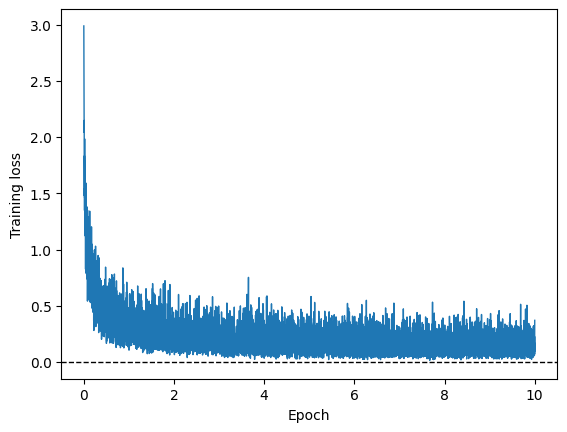

In [230]:
x_epoch = np.linspace(0, n_epochs, len(train_loss_logger))
plt.axhline(y=0, ls='--', color='k', lw=1)
plt.plot(x_epoch, train_loss_logger, lw=1)

xticks_format = plt.FuncFormatter(lambda y, pos: f'{int(y)}')
plt.gca().xaxis.set_major_formatter(xticks_format)
plt.xlabel('Epoch')
plt.ylabel('Training loss')
plt.savefig(os.path.join(fig_dir, '3_training_loss.png'),
            bbox_inches='tight', dpi=600)
plt.show()

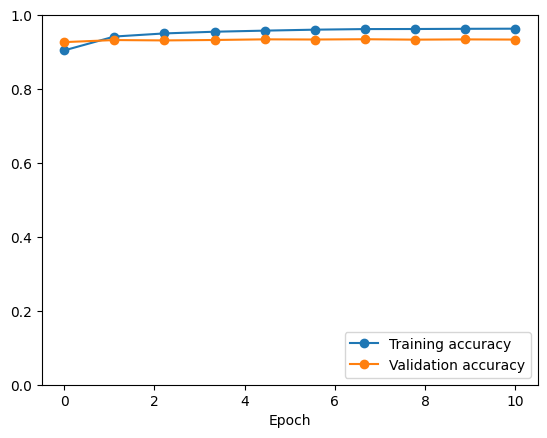

In [231]:
x_epoch = np.linspace(0, n_epochs, len(train_accuracy_logger))
plt.plot(x_epoch, train_accuracy_logger, marker='o', label='Training accuracy')

x_epoch = np.linspace(0, n_epochs, len(val_accuracy_logger))
plt.plot(x_epoch, val_accuracy_logger, marker='o', label='Validation accuracy')

plt.ylim([0, 1])
xticks_format = plt.FuncFormatter(lambda y, pos: f'{int(y)}')
plt.gca().xaxis.set_major_formatter(xticks_format)
plt.xlabel('Epoch')
plt.legend(loc = 'lower right')
plt.savefig(os.path.join(fig_dir, '4_training_validation_accuracy.png'),
            bbox_inches='tight', dpi=600)
plt.show()

## Model evaluation

### Useful functions

The function below puts testing data in the right format to be sent to the model.

In [101]:
def get_image_sections_and_boxes(image: NDArray,
                                 selective_search_params: dict,
                                 image_section_dim: Tuple[int, int]
                                 ) -> Tuple[torch.Tensor, NDArray]:

    # Read parameters from selective_search_params
    scale = selective_search_params['scale']
    sigma = selective_search_params['sigma']
    min_size = selective_search_params['min_size']
    max_n_proposals = selective_search_params['max_n_proposals']

    # Normalization transform
    transform = transforms.Normalize([0.485, 0.456, 0.406],
                                     [0.229, 0.224, 0.225])
    
    # Generate boxes
    _, boxes = selectivesearch.selective_search(image,
                                                scale=scale,
                                                sigma=sigma,
                                                min_size=min_size)
    boxes = [r['rect'] for r in boxes]
    boxes = [[x, y, x+w, y+h] for x, y, w, h in boxes if (w != 0) and (h != 0)]
    boxes = np.array(boxes[:max_n_proposals])

    # Isolate and process image sections
    image_sections = []
    for box in boxes:
        x1, y1, x2, y2 = box
        img_section = image[y1:y2, x1:x2]
        img_section = cv2.resize(img_section, image_section_dim)
        image_sections.append(img_section)
    image_sections = np.asarray(image_sections, dtype=np.float32)
    image_sections = torch.from_numpy(image_sections)
    image_sections = torch.permute(image_sections, (0, 3, 1, 2))
    image_sections = transform(image_sections)

    return image_sections, boxes

To streamline visual assessments of the model's performance, we reimplement a non-maximum suppression algorithm to take out irrelevant boxes.

In [143]:
def non_max_suppression(boxes: NDArray,
                        scores: list[float],
                        labels: list[int],
                        score_threshold: float = 0.5,
                        iou_threshold: float = 0.5):
    # Non-maximum suppression

    # Select boxes with high enough score
    idx = (scores > score_threshold)
    boxes = boxes[idx]
    scores = scores[idx]
    labels = labels[idx]

    # Select which boxes should be kept
    kept_boxes = []
    kept_scores = []
    kept_labels = []
    idx = np.argsort(scores)[::-1]  # Start from highest scores
    while len(idx):
        # Store reference (i.e., remaining highest-score box) and delete it from idx
        ref_box = boxes[idx[0]]
        ref_score = scores[idx[0]]
        ref_label = labels[idx[0]]
        kept_boxes.append(ref_box)
        kept_scores.append(ref_score)
        kept_labels.append(ref_label)
        idx = np.delete(idx, 0)

        # Delete other boxes from idx based on their label and iou with the reference
        i = 0
        while i < len(idx):
            if (labels[idx[i]] == ref_label):
                iou = compute_iou(boxes[idx[i]], ref_box)
                if iou >= iou_threshold:
                    idx = np.delete(idx, i)
            i += 1

    return np.array(kept_boxes), kept_scores, kept_labels

This non-maximum suppression is called when processing the model predictions.

In [155]:
def process_predictions(boxes: NDArray,
                        scores: list[float],
                        score_threshold: float = 0.5,
                        iou_threshold: float = 0.5):

    labels = np.argmax(scores, 1)
    label_scores = np.max(scores, 1)
    object_idx = (labels != 0)  # Non-background

    boxes, scores, labels = non_max_suppression(boxes=boxes[object_idx],
                                                scores=label_scores[object_idx],
                                                labels=labels[object_idx],
                                                score_threshold=score_threshold,
                                                iou_threshold=iou_threshold)
    
    return boxes, scores, labels

### Evaluation on a few test images

In [100]:
# Load best model
model.load_state_dict(torch.load('./rcnn_model.pt',
                                 weights_only=True))
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

/Users/alexis_reymbaut/Library/Python/3.9/lib/python/site-packages/skimage/feature/texture.py:360: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(


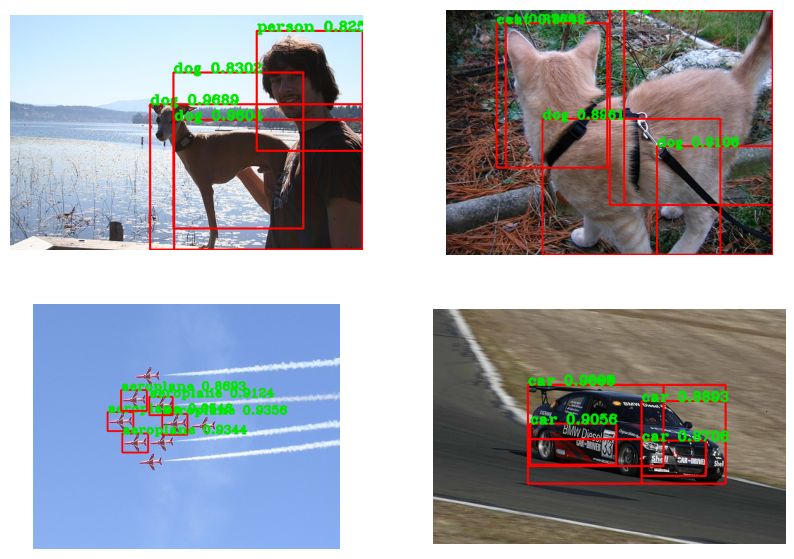

In [232]:
score_threshold = 0.75
iou_threshold = 0.5
selective_search_params = {
    'scale': 1000.,          # large values result in fewer regions but potentially higher quality
    'sigma': 0.8,            # std of Gaussian function smoothing the image
    'min_size': 50,          # discard too-small regions
    'max_n_proposals': 1000  # maximal number of proposals retained
}

_, ax = plt.subplots(2, 2, figsize=(10, 7))
ax = ax.flatten()

test_image_idx = [126, 336, 429, 2441]

for i in range(4):
    test_image = np.array(voc_dataset_test[test_image_idx[i]][0])
    image_sections, boxes \
        = get_image_sections_and_boxes(test_image,
                                       selective_search_params,
                                       image_section_dim=(pixel_size, pixel_size))
    with torch.no_grad():
        pred = model(image_sections.to(device))

    scores = torch.softmax(pred, 1).cpu().numpy()
    processed_boxes, processed_scores, processed_labels \
        = process_predictions(scores=scores,
                              boxes=boxes,
                              score_threshold=score_threshold,
                              iou_threshold=iou_threshold)

    processed_labels = [data_labels[x] for x in processed_labels]
    image = draw_image_boxes(img=test_image,
                             boxes=processed_boxes,
                             scores=processed_scores,
                             labels=processed_labels)
    ax[i].imshow(image)
    ax[i].axis('off')
plt.savefig(os.path.join(fig_dir, '5_some_predictions.png'),
            bbox_inches='tight', dpi=600)
plt.show()

**Breakdown:**
- The trained model seems to perform rather well, but does have limitations.
    - Some objects may remain undetected (see above planes).
    - Some of the selected boxes may be missclassified depending on their coverage (see above cat).
    - Selective search relies on multiple manually set hyperparameters and can yield quite messy box collections.
- These limitations may be alleviated upon refining the selective search and using data-augmentation techniques.
- One could also apply other models such as YOLO, which has become a standard in computer vision due to its speed (which may sometimes come at the cost of some accuracy).